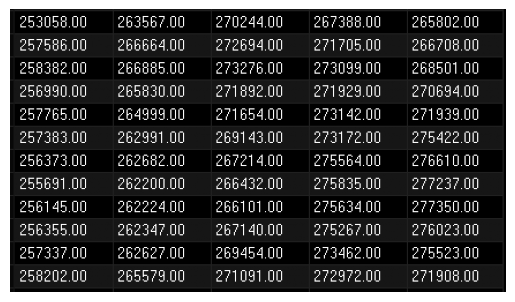

In [222]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('data/2025-01-12/img_test.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
## import os
import pyautogui
from PIL import Image
import tkinter as tk
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pytesseract
import pandas as pd
from matplotlib.collections import PolyCollection
import re

today = str(dt.datetime.now()).split(' ')[0]
try:
    os.mkdir(f'data/{today}')
except FileExistsError: # pass if the folder already exists
    pass
    
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
custom_config = r'--oem 3 --psm 6 outputbase digits'

def resizeFrame(event):
    if frame1 :
        frame1.place(x=40, rely=60/510, width=430, relheight=105/480)
        frame2.place(x=40, rely=1950/510, width=430, relheight=245/480)
        button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)
        
def getTargetRegion(root, frame2):
    root_position = root.wm_geometry()
    x = int(root_position.split('+')[1])
    y = int(root_position.split('+')[2])
    # w = root.winfo_width()
    # h = root.winfo_height()
    frame_geo = frame2.winfo_geometry()
    x_f = int(frame_geo.split('+')[1])
    y_f = int(frame_geo.split('+')[2])
    w_f = frame2.winfo_width()
    h_f = frame2.winfo_height()
    return (x+x_f+8,y+y_f+31,w_f,h_f) # numbers 12 and 57 added to adjust a region of being captured

def readNumbers(img):
    # apply a threshold to increase accuracy
    _, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    numbers = pytesseract.image_to_string(binary, config=custom_config)
    numbers_list = numbers.split('\n')
    while '' in numbers_list:
        numbers_list.remove('') # remove the element resulted fom \n
    return numbers_list

def fillRows(numbers_list):
    rows = []
    for idx, val in enumerate(numbers_list):
        rows.append(val.split('00'))
    for idx, val in enumerate(rows):
        if len(val) != 6: # replaced with regex
            rows[idx] = re.findall(r'[-+]?\d+\.00', numbers_list[idx])
        while '' in val:
            val.remove('')
        rows[idx] = list(map(float, rows[idx]))
    for i in range(len(rows)):
        for j in range(len(rows[0])):
            rows[i][j] = abs(rows[i][j])
    return rows

def topNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top['cm'] = [5+i for i in range(len(df_top))]
    df_top.set_index('cm', inplace=True)
    return df_top
    
def bottomNumbersToDf(start,numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[:,np.arange(len(df_bottom.columns)-1,-1,-1).tolist()] # reverse
    df_bottom['cm'] = [start+1+i for i in range(len(df_bottom))]
    df_bottom.set_index('cm', inplace=True)
    return df_bottom

def mergeDfs(dfs):
    return pd.concat([df for df in dfs])
    
def topPointNumbersToDf(numbers_list): # need to get position in cm
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top = df_top.astype(float)
    return pd.concat([df_top, df_top.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)
    
def bottomPointNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[:,np.arange(len(df_bottom.columns)-1,-1,-1).tolist()] # reverse
    df_bottom = df_bottom.astype(float)
    return pd.concat([df_bottom, df_bottom.agg(['count', 'min', 'max', 'mean', 'std'])]).round(3)

def preciseTopNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_top = pd.DataFrame(rows, columns=['W2','W1','C','E1','E2'])
    df_top['cm'] = [5+0.25*i for i in range(len(df_top))]
    df_top.set_index('cm', inplace=True)
    return df_top
    
def preciseBottomNumbersToDf(numbers_list):
    rows = fillRows(numbers_list)
    df_bottom = pd.DataFrame(rows, columns=['E2','E1','C','W1','W2']) # inverse order
    df_bottom = df_bottom.iloc[:,np.arange(len(df_bottom.columns)-1,-1,-1).tolist()] # reverse
    df_bottom['cm'] = [16-0.25*i for i in range(len(df_bottom))]
    df_bottom.set_index('cm', inplace=True)
    df_bottom = df_bottom.sort_index() # sort df by index
    return df_bottom
        
def topMeasurement(root, frame):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    df_top = topNumbersToDf(readNumbers(ss_gray))
    df_top.to_csv(f'data/{today}/1_top.csv', index=True)
    print('Top saved')
    
def drawHeatmap(df,annot): # heatmap
    fig, axs = plt.subplots()
    sns.heatmap(df/1000, annot=False, linewidths=0.5, cmap=plt.cm.GnBu,
                vmin=0, vmax=750, xticklabels=range(-6,9,3), yticklabels=df.index, cbar_kws={'label':'Thickness [um]'})
    axs.set(xlabel='X axis [cm]', ylabel='Y axis [cm]')
    fig.savefig(f'data/{today}/6_2d_{annot}.png')
    
def polygon_under_graph(x, z):
    return [(x[0], 0.), *zip(x, z), (x[-1], 0.)]
    
def draw3DPlot(df,annot):
    fig = plt.figure(figsize=(8,8))
    axs = fig.add_subplot(projection='3d')
    
    df = df.astype(float)
    x = range(-6,9,3) # fixed
    y = df.index.tolist()
    z = df.values.tolist()
    
    verts = [polygon_under_graph(x, z[i]) for i in range(len(y))]
    facefolors = ['yellow' if (val < 5.5) | (val > 15.5) else 'gray' for val in y]
    poly = PolyCollection(verts, facecolor=facefolors, edgecolor='black', alpha=.7)
    axs.add_collection3d(poly, zs=y, zdir='y')
    axs.set(xlim=(-6, 6), ylim=(y[0], y[-1]), zlim=(min(min(z)), max(max(z))),
           xlabel='X axis [cm]', ylabel='Y axis [cm]', zlabel='Thickness [um]')
    # axs.set_title('Surface uniformity', y=1)
    axs.set_box_aspect(None, zoom=0.8)
    axs.view_init(40, 45) 
    fig.savefig(f'data/{today}/3d_{annot}.png')

# def setFlag(y):
#     s = y[0] # start
#     e = y[-1] # end
#     if (s < 5.5) & (e <= 5.5):
#         return 1
#     elif (s < 5.5) & (e > 5.5) & (e <=15.5):
#         return 2
#     elif (s < 5.5) & (e > 15.5):
#         return 3
#     elif (s>=5.5) & (s<=15.5) & (e>=5.5) & (e<=15.5):
#         return 4
#     elif (s>=5.5) & (s<=15.5) & (e>15.5):
#         return 5
#     elif (s>=15.5) & (e>15.5)
#         return 6
#     return 0

# def draw3DPlot(df,annot):
#     x = range(-6,9,3) # fixed
#     y = df.index.tolist()
#     z = df.values.tolist()

#     # six combinations exist depending on y[0] and y[-1]
#     flag = setFlag(y)
#     print(flag)

#     if flag==1: # (t,t)
#         y_t = y
#         z_t = df / 1000 ###
#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         X_t, Y_t = np.meshgrid(x, y_t)
#         ax.plot_surface(X_t, Y_t, z_t, color='yellow', alpha=0.8)
#     elif flag==2: # (t,c)
#         y_t = []
#         y_c = []
#         for i in y:
#             if i < 5.5:
#                 y_t.append(i)
#             elif (i >= 5.5) & (i <= 15.5):
#                 y_c.append(i)
            
#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         # top
#         X_t, Y_t = np.meshgrid(x, y_t)
#         ax.plot_surface(X_t, Y_t, z_t, color='yellow', alpha=0.8)
#         # center
#         X_c, Y_c = np.meshgrid(x, y_c)
#         ax.plot_surface(X_c, Y_c, z_c, color='grey', alpha=0.8)
#     elif flag==3: # (t,b)
#         y_t = []
#         y_c = []
#         y_b = []  
#         for i in y:
#             if i < 5.5:
#                 y_t.append(i)
#             elif (i >= 5.5) & (i <= 15.5):
#                 y_c.append(i)
#             else:
#                 y_b.append(i)

#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         # top
#         X_t, Y_t = np.meshgrid(x, y_t)
#         ax.plot_surface(X_t, Y_t, z_t, color='yellow', alpha=0.8)
#         # center
#         X_c, Y_c = np.meshgrid(x, y_c)
#         ax.plot_surface(X_c, Y_c, z_c, color='grey', alpha=0.8)
#         # bottom
#         X_b, Y_b = np.meshgrid(x, y_b)
#         ax.plot_surface(X_b, Y_b, z_b, color='yellow', alpha=0.8)
#     elif flag==4: # (c,c)
#         y_c = y
#         z_c = df
#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         X_c, Y_c = np.meshgrid(x, y_c)
#         ax.plot_surface(X_c, Y_c, z_c, color='grey', alpha=0.8)
#     elif flag==5: # (c, b)
#         y_c = []
#         y_b = []
#         for i in y:
#             if (i >= 5.5) & (i <= 15.5):
#                 y_c.append(i)
#             else:
#                 y_b.append(i)
#         z_c = df.loc[y[0]:15.5] ###
#         z_b = df.loc[15.5:y[-1]] ###
#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         X_c, Y_c = np.meshgrid(x, y_c)
#         ax.plot_surface(X_c, Y_c, z_c, color='grey', alpha=0.8)
#         X_b, Y_b = np.meshgrid(x, y_b)
#         ax.plot_surface(X_b, Y_b, z_b, color='yellow', alpha=0.8)
#     else: # (b,b)
#         y_b = y
#         z_b = df
#         fig = plt.figure() #figsize=(10, 8)
#         ax = plt.axes(projection='3d')
#         X_b, Y_b = np.meshgrid(x, y_b)
#         ax.plot_surface(X_b, Y_b, z_b, color='yellow', alpha=0.8)
        
        
        
#     # z_t = tb.loc[5:7] / 1000 # nm to um
#     # z_c = tb.loc[8:12] / 1000
#     # z_b = tb.loc[13:] / 1000
       
#     ax.set(xlim=(-6, 6), ylim=(0,25), zlim=(0, 750),
#            xlabel='X axis [cm]', ylabel='Y axis [cm]', zlabel='Thickness [um]')
#     ax.view_init(40, 30)
#     plt.show()
    
def bottomMeasurement(root, frame):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    # df_top = pd.read_csv(f'data/{today}/top.csv',index_col='cm')
    df_bottom = bottomNumbersToDf(12,readNumbers(ss_gray))
    df_bottom.to_csv(f'data/{today}/2_bottom.csv', index=True)
    print('Bottom saved')
    # df_merged = mergeDfs([df_top, df_bottom])
    # df_merged = df_merged.astype(float)
    # df_merged.to_csv(f'data/{today}/top+bottom.csv', index=True)
    # print('Top & Bottom merged')
    # draw plots
    # drawHeatmap(df_merged,'top+bottom')
    # print('2D plot of top & bottom saved')
    # draw3DPlot(df_merged,'top+bottom')
    # print('3D plot of top & bottom saved')
    
def topPointMeasurement(root, frame): 
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    df_top_point = topPointNumbersToDf(readNumbers(ss_gray))
    df_top_point.to_csv(f'data/{today}/top_point.csv', index=True)
    print('Top point saved')

def bottomPointMeasurement(root, frame): 
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    df_bottom_point = bottomPointNumbersToDf(readNumbers(ss_gray))
    df_bottom_point.to_csv(f'data/{today}/bottom_point.csv', index=True)
    print('Bottom point saved')

def preciseTopMeasurement(root, frame):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    df_top = preciseTopNumbersToDf(readNumbers(ss_gray))
    df_top.to_csv(f'data/{today}/precise_top.csv', index=True)
    print('Top of precision saved')
    # plot
    drawHeatmap(df_top,'precise_top')
    print('2D plot of top of precision saved')

def preciseBottomMeasurement(root, frame):
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2))
    ss_gray = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY) # ss stands for screenshot..
    df_bottom = preciseBottomNumbersToDf(readNumbers(ss_gray))
    df_bottom.to_csv(f'data/{today}/precise_bottom.csv', index=True)
    print('Bottom of precision saved')
    # plot the bottom first
    drawHeatmap(df_bottom,'precise_bottom')
    print('2D plot of bottom of precision saved')    

def getFinalResults(root, frame):
    df_tb = pd.read_csv(f'data/{today}/top+bottom.csv', index_col='cm') # top+bottom
    df_pt = pd.read_csv(f'data/{today}/precise_top.csv',index_col='cm') # precise top
    df_pb = pd.read_csv(f'data/{today}/precise_bottom.csv',index_col='cm') # precise bottom
    df_all = mergeDfs([df_tb, df_pt, df_pb])
    df_all = df_all.groupby('cm').mean() # average out rows having the same index
    df_all.to_csv(f'data/{today}/top+bottom+precision.csv', index=True)
    # plots
    drawHeatmap(df_all,'top+bottom+precision')
    print('2D plot of final data saved')
    draw3DPlot(df_all,'top+bottom+precision')
    print('3D plot of final data saved')
    
def savePNG(root, frame, name): # get a file name as an input
    screenshot = pyautogui.screenshot(region=getTargetRegion(root, frame2)) # must concern the aread inside the transparent frame
    screenshot.save(f'data/{today}/img_{name}.PNG')
    print(f'{name}.png saved') # change a color of button
    
root = tk.Tk()
# root.configure(bg='gray')
root.geometry('510x480+0+510')
root.wm_attributes('-transparentcolor', 'red')

# make this transparent frame adjustable
frame1 = tk.Frame(root, bg='red')
frame1.place(x=40, rely=60/480, width=430, relheight=105/510) #(x=40, y=60, width=430, height=105)

l = tk.Label(root, text = "W1      W2      C      E1      E2")
l.place(x=70, rely=170/510)
l.config(font =("Courier", 14))

frame2 = tk.Frame(root, bg='red')
frame2.place(x=40, rely=195/480, width=430, relheight=245/510) #(x=40, y=195, width=430, height=245)

# frame for buttons
fr=tk.Frame(root, background="red")
fr.grid(rowspan=1, columnspan=4)


#buttons 
button1 = tk.Button(root, text="T Point", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, topPointMeasurement(root, frame2)])
button1.place(relx=0.08, rely=0.01, relwidth=0.1, relheight=0.1)

button2 = tk.Button(root, text="B Point", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, bottomPointMeasurement(root, frame2)])
button2.place(relx=0.2, rely=0.01, relwidth=0.1, relheight=0.1)

button3 = tk.Button(root, text="Ts", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, topMeasurement(root, frame2)])
button3.place(relx=0.33, rely=0.01, relwidth=0.1, relheight=0.1)

button4 = tk.Button(root, text="Bs", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, bottomMeasurement(root, frame2)])
button4.place(relx=0.45, rely=0.01, relwidth=0.1, relheight=0.1)

button5 = tk.Button(root, text="Precise\nTs", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, preciseTopMeasurement(root, frame2)])
button5.place(relx=0.58, rely=0.01, relwidth=0.1, relheight=0.1)

button6 = tk.Button(root, text="Precise\nBs", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, preciseBottomMeasurement(root, frame2)])
button6.place(relx=0.7, rely=0.01, relwidth=0.1, relheight=0.1)

button7 = tk.Button(root, text="Final\nResult", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame2.update, getFinalResults(root, frame2)])
button7.place(relx=0.82, rely=0.01, relwidth=0.1, relheight=0.1)


# button at the bottom to save imgs
ll = tk.Label(root, text="Img name : ")
ll.place(relx=0.26, rely=470/510)
entry=tk.Entry(root, width=11, insertontime=600)
entry.grid(row=0, column=1)
entry.place(relx=0.4, rely=470/510, height=20)
button8 = tk.Button(root, text="Save", font=('serif', 8, 'bold'), 
                    command=lambda: [root.update(), frame.update, savePNG(root, frame, entry.get())])
button8.place(relx=0.58, rely=470/510, relwidth=0.1, height=25)

# root.bind('<Configure>', resizeFrame)
root.title("Measurement of Wet Etching Rate")
root.attributes('-topmost', True)
root.mainloop()

Ref. 3_v-notch_E.png saved
Top saved
Ref. 3_v-notch_E.png saved
